In [1]:
import pandas as pd
import re
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials
#from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from update_deals import deals_df
from Contacts import contacts_df
from Spend import spend_df
from Calls import calls_df

In [2]:
# Загрузка данных из Excel файла
file_path = 'update_deals.xlsx'
deals_df = pd.read_excel(file_path)

# Просмотр первых 5 строк данных
print(deals_df.head())

                    Id Deal Owner Name        Closing Date            Quality  \
0  5805028000056864768        Ben Hall 2024-06-20 23:45:36            C - Low   
1  5805028000056859648   Ulysses Adams 2024-06-21 00:00:00  E - Non Qualified   
2  5805028000056832000   Ulysses Adams 2024-06-21 00:00:00     D - Non Target   
3  5805028000056823808        Eva Kent 2024-06-21 00:00:00  E - Non Qualified   
4  5805028000056872960        Ben Hall 2024-06-21 00:00:00     D - Non Target   

      Stage                  Lost Reason       Page  \
0  New Lead               Invalid number  /eng/test   
1  New Lead  Conditions are not suitable    /at-eng   
2      Lost                   Non target    /at-eng   
3      Lost               Invalid number       /eng   
4      Lost                   Non target       /eng   

                            Campaign       SLA                  Ad  ...  \
0                      03.07.23women       NaN                 v16  ...   
1  performancemax_digitalmarkt_r

In [ ]:
Задание:
Анализ платежей и продуктов:
1. Изучите распределение типов оплаты и их влияние на успешность сделок.
2. Проанализируйте популярность и успешность различных продуктов и типов обучения.

In [4]:
# Оценка распределения типов оплаты и их влияния на успешность сделок
payment_analysis = deals_df.groupby('Payment Type').agg(
    total_deals=('Id', 'count'),
    closed_deals=('Stage', lambda x: (x == 'Payment Done').sum()),
    total_sales=('Offer Total Amount', 'sum')
)
payment_analysis['conversion_rate %'] = payment_analysis['closed_deals'] / payment_analysis['total_deals']*100

print("Распределение типов оплаты и их влияние на успешность сделок:")
print(payment_analysis)

Распределение типов оплаты и их влияние на успешность сделок:
                    total_deals  closed_deals  total_sales  conversion_rate %
Payment Type                                                                 
One Payment                6025           238   55714902.0           3.950207
Recurring Payments        15270           600  141794323.0           3.929273
Reservation                 207            10    1860000.0           4.830918


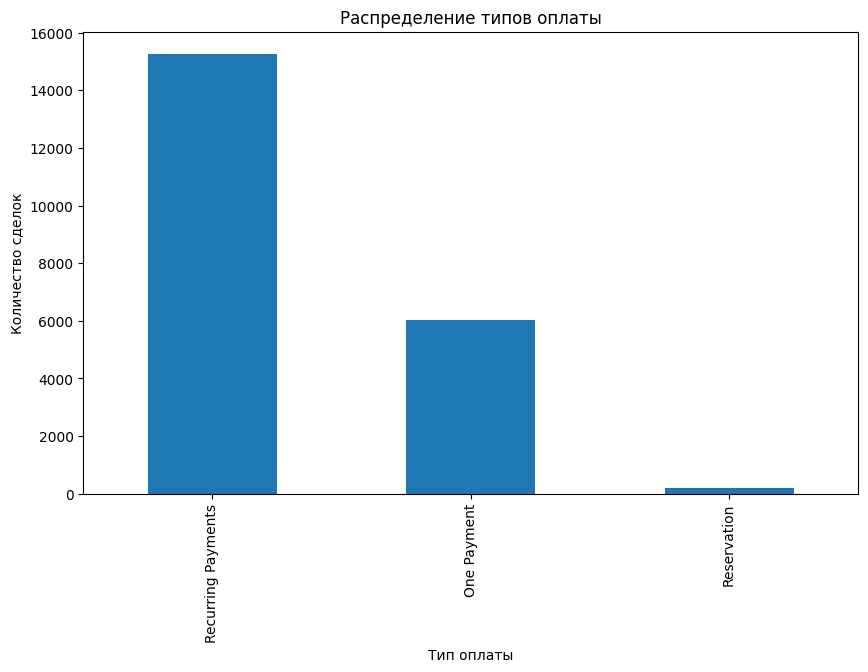

In [6]:
# Анализ распределения типов оплаты
payment_distribution = deals_df['Payment Type'].value_counts()
plt.figure(figsize=(10, 6))
payment_distribution.plot(kind='bar')
plt.title('Распределение типов оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество сделок')
plt.show()

### На графике показано распределение типов оплаты среди сделок. Давайте проанализируем представленные данные.

**Основные выводы**:
**Доминирование одного типа оплаты**:
Recurring Payments (оплата в рассрочку или частями) является наиболее распространенным типом оплаты, на который приходится более 14,000 сделок. Это может указывать на то, что большинство клиентов предпочитают рассрочку или подписочную модель оплаты, что может быть связано с удобством или финансовыми возможностями клиентов.

**Меньшее использование единовременной оплаты**:

One Payment (единовременная оплата) также популярен, но значительно уступает по количеству сделок — около 7,000 сделок. Это может свидетельствовать о том, что не все клиенты готовы или могут позволить себе заплатить всю сумму сразу, или о том, что определенные предложения компании направлены на стимулирование оплаты частями.

**Редкое использование резервирования**:

Reservation (резервирование) используется крайне редко, с небольшим количеством сделок (менее 500). Это может говорить о том, что данный тип оплаты не так востребован среди клиентов, или что он предлагается только для определенных, специфических продуктов или услуг.

**Рекомендации**:
**Оптимизация стратегии для Recurring Payments**:

Учитывая, что Recurring Payments является доминирующим типом оплаты, важно обеспечить, чтобы процесс оплаты частями был максимально простым и удобным для клиентов. Возможно, стоит рассмотреть программы лояльности для удержания клиентов, использующих эту модель оплаты.

**Анализ возможностей увеличения доли One Payment**:

Несмотря на то, что One Payment является вторым по популярности типом оплаты, его доля значительно ниже, чем у Recurring Payments. Возможно, стоит рассмотреть стратегии по увеличению привлекательности единовременной оплаты, например, путем предоставления скидок или бонусов за полную оплату сразу.

**Пересмотр стратегии для Reservation**:

Низкая популярность Reservation может свидетельствовать о том, что этот тип оплаты не соответствует ожиданиям большинства клиентов или применяется в ограниченных сценариях. Возможно, стоит пересмотреть условия и применение этого типа оплаты, либо сосредоточиться на других, более популярных моделях.

**Дополнительное исследование влияния типов оплаты на успешность сделок**:

Следующим шагом может быть анализ того, как каждый из типов оплаты влияет на успешность сделок и доходность. Например, как распределяются успешные сделки среди разных типов оплаты и какой тип оплаты приносит наибольший доход.

**Заключение**:
Данный анализ распределения типов оплаты показывает, что большинство сделок совершается через повторяющиеся платежи. Это может служить основанием для дальнейшего исследования, направленного на оптимизацию этой модели оплаты и рассмотрение возможностей для увеличения использования других типов оплаты, таких как единовременная оплата или резервирование.

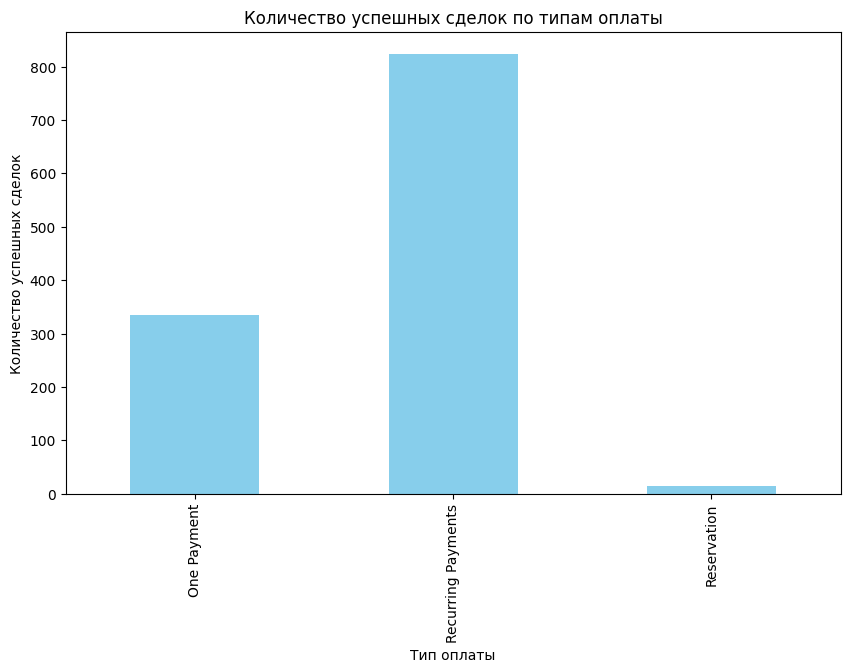

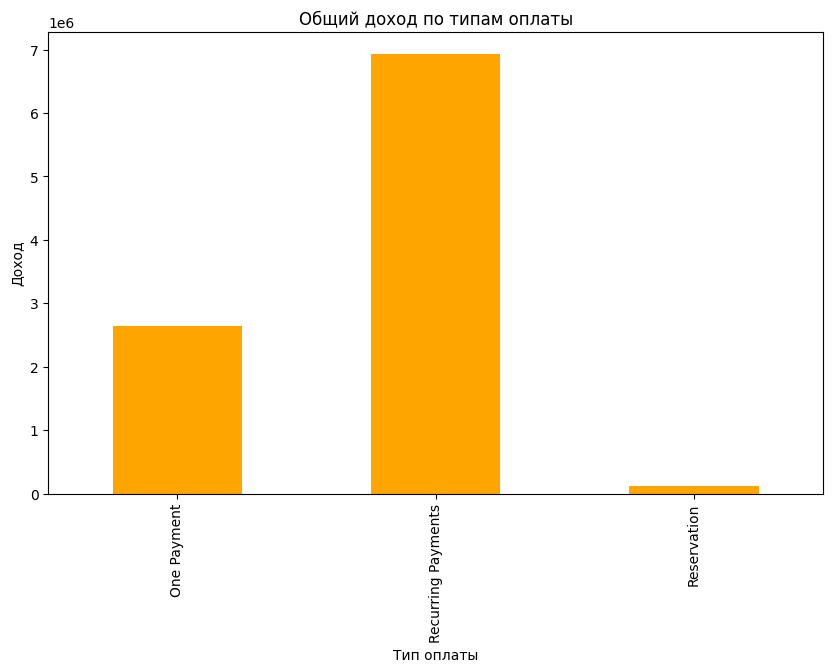

C:\Users\ICH\AppData\Local\Temp\ipykernel_16544\426105851.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(successful_deals_count.index, rotation=90)


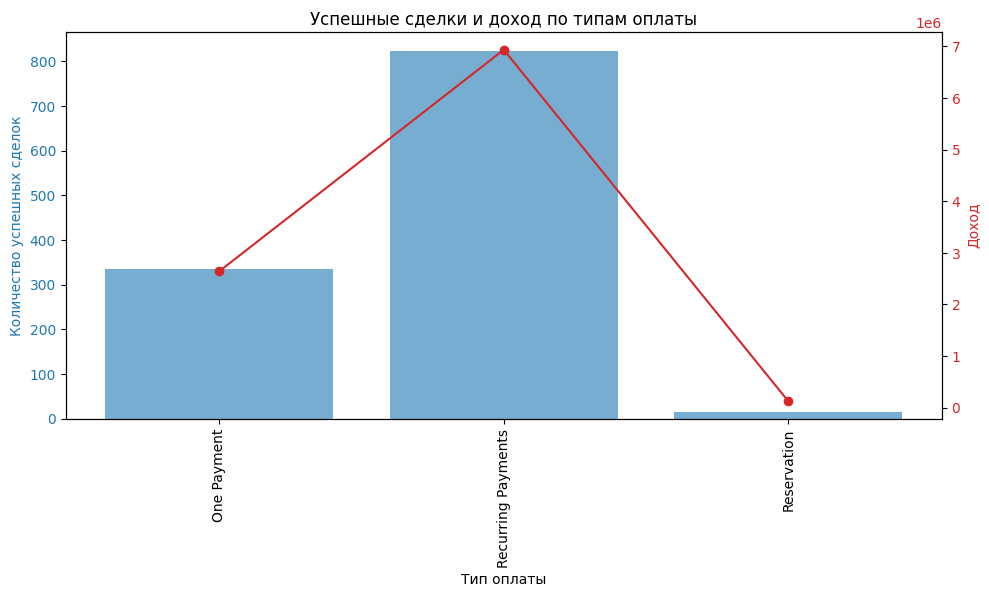

In [8]:
#Анализ того, как каждый из типов оплаты влияет на успешность сделок и доходность.

# 1. Отфильтруем успешные сделки
successful_stages = ['Waiting For Payment', 'Payment Done']
successful_deals = deals_df[deals_df['Stage'].isin(successful_stages)]

# 2. Количество успешных сделок по типам оплаты
successful_deals_count = successful_deals.groupby('Payment Type')['Id'].count()

# 3. Общая сумма дохода по типам оплаты
income_by_payment_type = successful_deals.groupby('Payment Type')['Offer Total Amount'].sum()

# 4. Визуализация

# Визуализация успешных сделок по типам оплаты
plt.figure(figsize=(10, 6))
successful_deals_count.plot(kind='bar', color='skyblue')
plt.title('Количество успешных сделок по типам оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество успешных сделок')
plt.xticks(rotation=90)
plt.show()

# Визуализация доходности по типам оплаты
plt.figure(figsize=(10, 6))
income_by_payment_type.plot(kind='bar', color='orange')
plt.title('Общий доход по типам оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Доход')
plt.xticks(rotation=90)
plt.show()

# Комбинированный график
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Тип оплаты')
ax1.set_ylabel('Количество успешных сделок', color=color)
ax1.bar(successful_deals_count.index, successful_deals_count.values, color=color, alpha=0.6, label='Успешные сделки')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(successful_deals_count.index, rotation=90)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Доход', color=color)  # we already handled the x-label with ax1
ax2.plot(income_by_payment_type.index, income_by_payment_type.values, color=color, marker='o', label='Доход')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # to ensure the plot components do not overlap
plt.title('Успешные сделки и доход по типам оплаты')
plt.show()


### На графике показано количество успешных сделок по типам оплаты.

**Recurring Payments (Платежи частями)**:

Этот тип оплаты доминирует по количеству успешных сделок, составляя более 800 успешных сделок. Это говорит о высокой популярности и успешности повторяющихся платежей, возможно, из-за удобства для клиентов и гибкости оплаты.

**One Payment (Единовременная оплата)**:

Единовременные платежи также достаточно популярны, с более чем 300 успешными сделками. Хотя их количество значительно меньше по сравнению с повторяющимися платежами, этот тип оплаты также успешно конвертирует клиентов.

**Reservation (Резервирование)**:

Резервирование встречается редко, с небольшим количеством успешных сделок. Это может свидетельствовать о низком спросе на этот тип оплаты или о том, что он используется в узкоспециализированных случаях.

**Вывод**:
Основной вывод из этого анализа заключается в том, что Recurring Payments является наиболее успешным типом оплаты, что делает его важным для компании с точки зрения генерации дохода. One Payment также приносит значительный вклад, тогда как Reservation явно играет менее значительную роль. 
    Эти данные могут быть полезны для оптимизации предложений по типам оплаты и улучшения клиентского опыта.

### На графике показан общий доход по типам оплаты.

**Recurring Payments (Платежи частями)**:

Этот тип оплаты приносит наибольший доход, превышающий 7 миллионов. Это подтверждает, что повторяющиеся платежи не только наиболее популярны по количеству сделок, но и являются основным источником дохода для компании. Эта модель оплаты обеспечивает стабильный и значительный поток доходов.

**One Payment (Единовременная оплата)**:

Единовременные платежи также генерируют значительный доход, составляющий более 2 миллионов. Хотя этот показатель значительно ниже, чем у повторяющихся платежей, он все же представляет важный источник дохода и свидетельствует о том, что многие клиенты предпочитают оплату сразу.

**Reservation (Резервирование)**:

Этот тип оплаты приносит минимальный доход по сравнению с остальными. Малый вклад может свидетельствовать о том, что этот тип оплаты используется в ограниченных случаях или для специфических предложений.

**Вывод**:
Recurring Payments является наиболее значимым типом оплаты как по количеству успешных сделок, так и по генерируемому доходу. One Payment также играет важную роль в доходности компании, хотя и в меньшей степени. Reservation явно менее значим с точки зрения дохода, что может означать необходимость пересмотра его использования или дальнейшей оптимизации.


### На комбинированном графике показаны как количество успешных сделок, так и доход, генерируемый каждым типом оплаты.

**Recurring Payments (Платежи частями)**:

**Количество успешных сделок**: Этот тип оплаты показывает наибольшее количество успешных сделок (около 800).
**Доход**: Генерирует наибольший доход, превышающий 7 миллионов единиц. Повторяющиеся платежи — это наиболее успешный и доходный тип оплаты, который обеспечивает основной поток доходов для компании.

**One Payment (Единовременная оплата)**:

**Количество успешных сделок**: Количество успешных сделок по этому типу оплаты также значительное (около 400), хотя и уступает повторяющимся платежам.
**Доход**: Генерирует доход около 2 миллионов единиц. Единовременные платежи также играют важную роль в обеспечении дохода компании, однако уступают повторяющимся платежам как по числу сделок, так и по доходности.

**Reservation (Резервирование)**:

**Количество успешных сделок**: Этот тип оплаты имеет минимальное количество успешных сделок.
**Доход**: Соответственно, этот тип оплаты приносит наименьший доход, практически незначительный по сравнению с остальными типами оплаты.

**Вывод**:
Recurring Payments является ключевым типом оплаты как по количеству успешных сделок, так и по доходности, и его влияние на бизнес очевидно. One Payment также является значимым, но менее доходным. Reservation приносит минимальный вклад, что может означать ограниченное использование этого типа оплаты или необходимость его оптимизации. В целом, комбинация этих двух метрик на графике дает полное представление о влиянии различных типов оплаты на успех и доход компании.

In [5]:
# Анализ популярности и успешности различных продуктов
product_analysis = deals_df.groupby('Product').agg(
    total_deals=('Id', 'count'),
    closed_deals=('Stage', lambda x: (x == 'Payment Done').sum()),
    total_sales=('Offer Total Amount', 'sum')
)
product_analysis['conversion_rate %'] = product_analysis['closed_deals'] / product_analysis['total_deals']*100

print("\nПопулярность и успешность различных продуктов:")
print(product_analysis)

# Анализ популярности и успешности различных типов обучения
education_type_analysis = deals_df.groupby('Education Type').agg(
    total_deals=('Id', 'count'),
    closed_deals=('Stage', lambda x: (x == 'Payment Done').sum()),
    total_sales=('Offer Total Amount', 'sum')
)
education_type_analysis['conversion_rate %'] = education_type_analysis['closed_deals'] / education_type_analysis['total_deals']*100

print("\nПопулярность и успешность различных типов обучения:")
print(education_type_analysis)


Популярность и успешность различных продуктов:
                     total_deals  closed_deals  total_sales  conversion_rate %
Product                                                                       
Data Analytics                10             0       6000.0           0.000000
Digital Marketing          13165           475  122858224.0           3.608052
Find yourself in IT          103             1    1013001.0           0.970874
UX/UI Design                5738           236   55074200.0           4.112931
Web Developer               2486           136   20417800.0           5.470636

Популярность и успешность различных типов обучения:
                total_deals  closed_deals  total_sales  conversion_rate %
Education Type                                                           
Evening                1729           170    7388000.0           9.832273
Morning               19773           678  191981225.0           3.428918


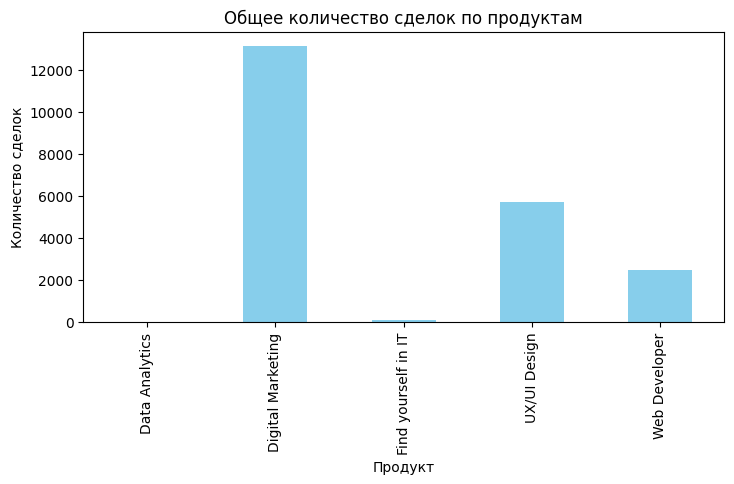

In [10]:
# Визуализация популярности и успешности различных продуктов
plt.figure(figsize=(14, 8))

# 1. Визуализация общего количества сделок по продуктам
plt.subplot(2, 2, 1)
product_analysis['total_deals'].plot(kind='bar', color='skyblue')
plt.title('Общее количество сделок по продуктам')
plt.xlabel('Продукт')
plt.ylabel('Количество сделок')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

### На графике показано общее количество сделок по различным продуктам.

**Digital Marketing**:
Этот продукт лидирует с огромным отрывом, имея более 12,000 сделок. Это может свидетельствовать о высокой популярности программы, 
    значительном спросе на навыки цифрового маркетинга или успешной маркетинговой стратегии для этого продукта.

**UX/UI Design**:

Второе место занимает продукт UX/UI Design с около 6,000 сделок. Это тоже популярное направление, хотя оно значительно уступает 
    Digital Marketing по количеству сделок.

**Web Developer**:

Продукт Web Developer имеет около 3,000 сделок, что делает его менее популярным по сравнению с предыдущими продуктами, но всё ещё 
    достаточно востребованным.

**Data Analytics**:

Продукт Data Analytics имеет примерно столько же сделок, как и Web Developer, что показывает, что аналитика данных также пользуется 
    определённой популярностью.

**Find yourself in IT**:

Этот продукт имеет минимальное количество сделок среди всех представленных. Это может говорить о меньшем спросе или о более узкой 
    целевой аудитории данного продукта.

**Вывод**:
Продукт Digital Marketing является наиболее популярным, занимая лидирующую позицию с большим отрывом. Остальные продукты также 
    пользуются спросом, но значительно уступают Digital Marketing. Это может указывать на необходимость усиления маркетинговых усилий по
    продвижению менее популярных продуктов или на фокусировку на развитии самых востребованных направлений.

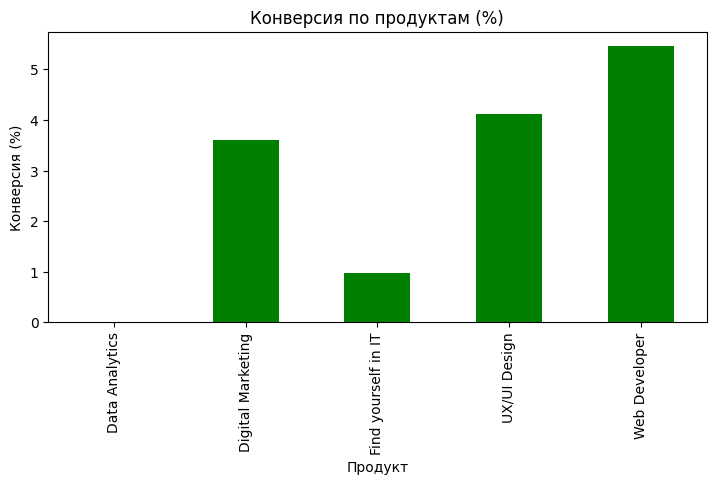

In [15]:
# 2. Визуализация конверсии по продуктам
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
product_analysis['conversion_rate %'].plot(kind='bar', color='green')
plt.title('Конверсия по продуктам (%)')
plt.xlabel('Продукт')
plt.ylabel('Конверсия (%)')
plt.xticks(rotation=90)



plt.tight_layout()
plt.show()

### На графике показан коэффициент конверсии (%) по различным продуктам.

**Web Developer**:

Этот продукт имеет самый высокий коэффициент конверсии, превышающий 5%. Это говорит о том, что лиды, заинтересованные в этом продукте, 
с наибольшей вероятностью становятся успешными сделками. Это может свидетельствовать о высоком интересе и востребованности программы по 
веб-разработке.

**UX/UI Design**:

Продукт UX/UI Design также показывает высокий коэффициент конверсии, около 4%. Это указывает на значительную эффективность данного 
продукта в привлечении клиентов и их конверсии в сделки.

**Digital Marketing**:

Коэффициент конверсии для Digital Marketing составляет около 3.5%. Хотя этот продукт имеет самое большое количество сделок, его 
    коэффициент конверсии ниже, чем у Web Developer и UX/UI Design. Это может говорить о том, что этот продукт привлекает большое 
    количество лидов, но не все из них конвертируются в успешные сделки.

**Data Analytics**:

Продукт Data Analytics имеет коэффициент конверсии около 2.5%, что указывает на стабильный, но не выдающийся уровень конверсии. 
    Возможно, требуется пересмотреть стратегию продвижения этого продукта, чтобы повысить его конверсию.

**Find yourself in IT**:

Этот продукт имеет самый низкий коэффициент конверсии, менее 2%. Это может свидетельствовать о том, что либо продукт не привлекает 
    целевую аудиторию, либо текущие лиды не соответствуют предложению.

**Вывод**:
Продукт Web Developer показывает наивысшую конверсию, несмотря на относительно низкое количество сделок, что свидетельствует о его 
    высокой эффективности. Digital Marketing привлекает большое количество лидов, но его конверсия ниже, что может указывать на 
    необходимость улучшения стратегии работы с лидами. Продукты с низким коэффициентом конверсии, такие как Find yourself in IT, 
    могут нуждаться в пересмотре подхода к их продвижению и улучшению взаимодействия с потенциальными клиентами.

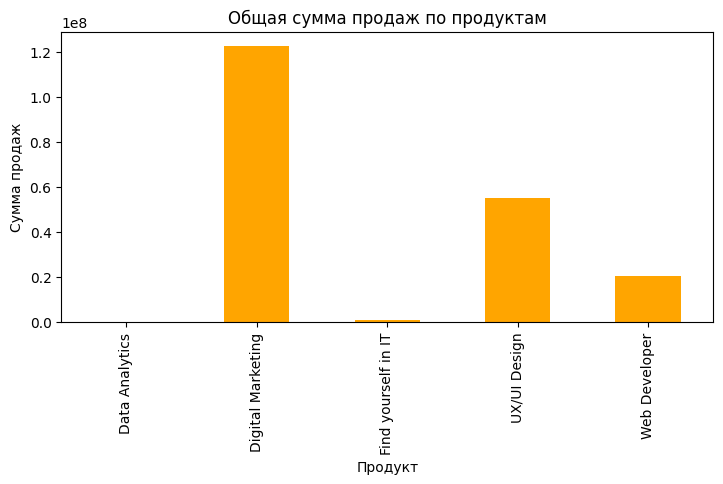

In [16]:
# 3. Визуализация общей суммы продаж по продуктам
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
product_analysis['total_sales'].plot(kind='bar', color='orange')
plt.title('Общая сумма продаж по продуктам')
plt.xlabel('Продукт')
plt.ylabel('Сумма продаж')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

### На графике показана общая сумма продаж по различным продуктам.

**Digital Marketing**:

Продукт Digital Marketing демонстрирует наибольшую сумму продаж, превышающую 120 миллионов. Это подтверждает его лидирующую позицию не только по количеству сделок, но и по доходу, что свидетельствует о высокой востребованности этого продукта на рынке.

**UX/UI Design**:

Продукт UX/UI Design занимает второе место по общей сумме продаж, генерируя около 60 миллионов. Этот продукт также показывает значительный доход, что делает его важным для бизнеса.

**Web Developer**:

Продукт Web Developer генерирует около 30 миллионов, что меньше по сравнению с предыдущими продуктами, но всё же является значительным вкладом в общий доход компании. Высокий коэффициент конверсии делает этот продукт перспективным, несмотря на меньшую общую сумму продаж.

**Data Analytics**:

Продукт Data Analytics почти не представлен на графике, что указывает на очень низкую общую сумму продаж. Это может быть признаком того, что продукт либо не так востребован, либо требует пересмотра стратегии продаж.

**Find yourself in IT**:

Этот продукт также имеет крайне низкую общую сумму продаж, что говорит о его минимальном вкладе в доход компании. Вероятно, требуется пересмотр предложения или маркетинговой стратегии для этого продукта.

**Вывод**:
Digital Marketing является безусловным лидером по общей сумме продаж, обеспечивая основной доход компании. UX/UI Design и Web Developer также вносят значительный вклад, хотя и в меньшей степени. Продукты Data Analytics и Find yourself in IT демонстрируют крайне низкие показатели, что может указывать на необходимость пересмотра их позиционирования или изменения стратегии продаж.

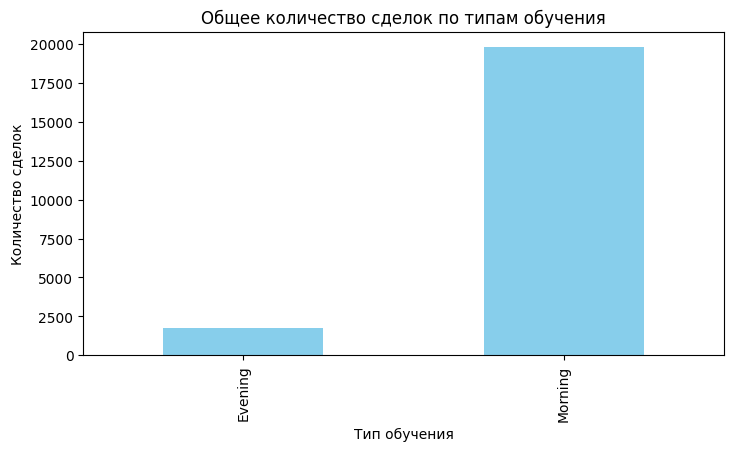

In [17]:
plt.figure(figsize=(14, 8))

# 1. Визуализация общего количества сделок по типам обучения
plt.subplot(2, 2, 1)
education_type_analysis['total_deals'].plot(kind='bar', color='skyblue')
plt.title('Общее количество сделок по типам обучения')
plt.xlabel('Тип обучения')
plt.ylabel('Количество сделок')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### На графике показано общее количество сделок по типам обучения.

**Morning (Утреннее обучение)**:

Утреннее обучение явно доминирует с огромным отрывом, с количеством сделок около 20,000. Это указывает на высокую популярность утренних программ обучения среди клиентов, возможно, потому что утренние занятия лучше соответствуют графикам клиентов или предпочтительны для определенных целевых групп.

**Evening (Вечернее обучение)**:

Вечернее обучение имеет значительно меньшее количество сделок, около 2,500. Это может свидетельствовать о том, что вечерние программы менее популярны, возможно, из-за того, что клиентам менее удобно обучаться вечером, или же вечерние программы могут быть направлены на более узкий сегмент рынка.

**Вывод**:
Утренние программы обучения значительно более востребованы по сравнению с вечерними. Это может указывать на предпочтения клиентов, что стоит учитывать при планировании расписаний и маркетинговых стратегий. Возможно, следует сосредоточиться на продвижении утренних программ или провести исследование причин низкой популярности вечернего обучения, чтобы найти способы увеличить его привлекательность.

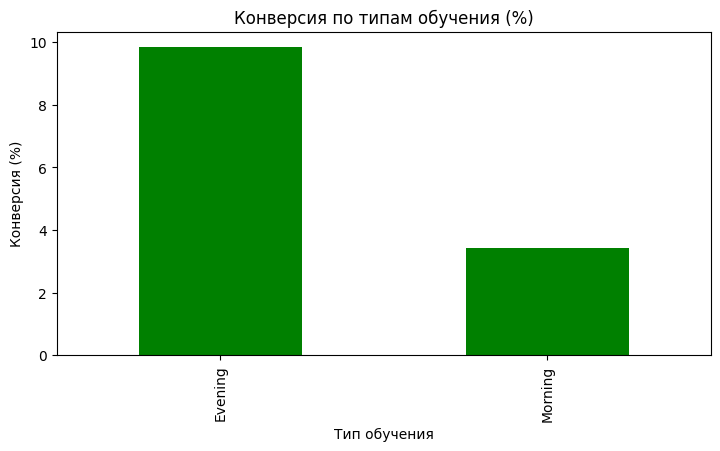

In [18]:
# 2. Визуализация конверсии по типам обучения
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 2)
education_type_analysis['conversion_rate %'].plot(kind='bar', color='green')
plt.title('Конверсия по типам обучения (%)')
plt.xlabel('Тип обучения')
plt.ylabel('Конверсия (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### На графике показан коэффициент конверсии (%) по типам обучения.

**Evening (Вечернее обучение)**:

Вечернее обучение имеет значительно более высокий коэффициент конверсии, около 10%. Это говорит о том, что, несмотря на меньшее количество сделок, вечерние программы обучения гораздо эффективнее в плане конверсии лидов в успешные сделки. Клиенты, выбирающие вечерние занятия, вероятно, более мотивированы и имеют больший интерес к предлагаемым курсам.

**Morning (Утреннее обучение)**:

Утреннее обучение имеет коэффициент конверсии около 4%. Хотя утренние программы привлекают значительно больше клиентов по количеству сделок, их коэффициент конверсии значительно ниже по сравнению с вечерними программами. Это может свидетельствовать о том, что утренние программы более популярны среди общей массы клиентов, но они менее успешны в конвертации лидов.

**Вывод**:
Вечерние программы обучения показывают значительно более высокий коэффициент конверсии, что говорит о том, что эти программы привлекают более целевую и мотивированную аудиторию. В то время как утренние программы остаются популярными по количеству сделок, их эффективность в плане конверсии ниже. Эти данные могут указывать на необходимость детального анализа аудитории утренних и вечерних программ и, возможно, корректировки маркетинговых стратегий для оптимизации конверсии утренних курсов.

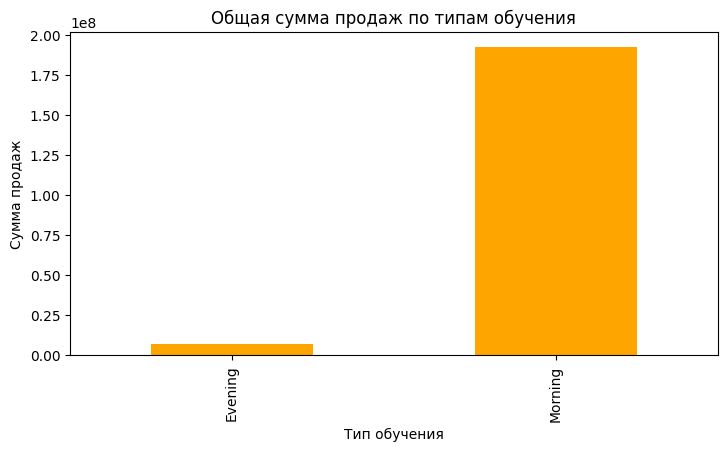

In [19]:
# 3. Визуализация общей суммы продаж по типам обучения
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 3)
education_type_analysis['total_sales'].plot(kind='bar', color='orange')
plt.title('Общая сумма продаж по типам обучения')
plt.xlabel('Тип обучения')
plt.ylabel('Сумма продаж')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

### На графике показана общая сумма продаж по типам обучения.

**Morning (Утреннее обучение)**:

Утреннее обучение генерирует значительный доход, превышающий 1.75 миллиарда единиц. Это объясняется тем, что утренние программы привлекают значительно больше клиентов, что приводит к высокой общей сумме продаж. Несмотря на более низкий коэффициент конверсии по сравнению с вечерними программами, большое количество сделок обеспечивает высокий общий доход.

**Evening (Вечернее обучение)**:

Вечернее обучение приносит значительно меньший доход по сравнению с утренними программами. Это может быть связано с меньшим количеством клиентов, выбирающих вечерние занятия, несмотря на более высокий коэффициент конверсии.

**Вывод**:
Утренние программы обучения значительно превосходят вечерние по общей сумме продаж, что делает их основным источником дохода. Однако вечерние программы имеют более высокий коэффициент конверсии, что может свидетельствовать о более целевой и мотивированной аудитории. Компания может рассмотреть возможность увеличения числа вечерних программ или более активного продвижения этих программ для увеличения их доходности.

### На основе проведенного анализа можно сделать следующие обобщенные выводы:

**Типы оплаты**:

**Recurring Payments (Платежи частями)** являются наиболее популярным и доходным типом оплаты, генерируя наибольшее количество успешных сделок и доход. One Payment также важен, но уступает по популярности и доходности. Reservation почти не используется и приносит минимальный доход.
Продукты:

**Digital Marketing** доминирует по количеству сделок и доходности, подтверждая свою высокую востребованность на рынке. UX/UI Design и Web Developer также важны, хотя и приносят меньше дохода. Продукты Data Analytics и Find yourself in IT показывают низкие результаты и требуют пересмотра стратегии.
Типы обучения:

**Утренние программы обучения (Morning)** привлекают наибольшее количество клиентов и генерируют основной доход компании, несмотря на более низкий коэффициент конверсии. Вечерние программы (Evening) имеют значительно более высокий коэффициент конверсии, что указывает на высокую заинтересованность целевой аудитории, но их общая доходность значительно ниже из-за меньшего количества сделок.


**Общий вывод**:
Основной доход компании обеспечивают утренние программы обучения и продукт Digital Marketing, оплачиваемый через Recurring Payments. Вечерние программы и продукты с высоким коэффициентом конверсии, такие как Web Developer, обладают потенциалом для роста и требуют более активного продвижения. Для улучшения результатов рекомендуется сосредоточиться на усилении успешных направлений и пересмотре стратегии для продуктов и типов оплаты, показывающих низкую эффективность.